In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import scipy.signal as signal
from scipy.signal import find_peaks
import shutil

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff,fs=fs, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

fs2:1347.6738617701374


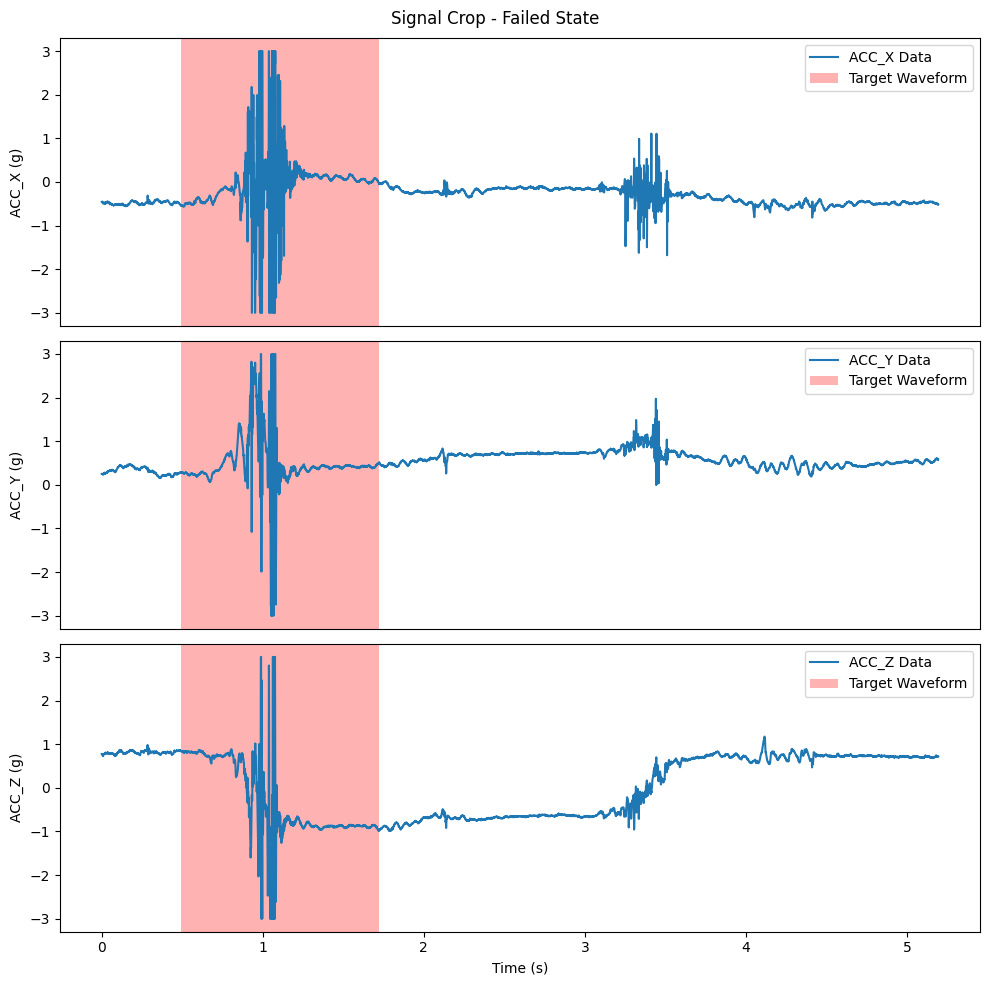

(670, 2332)

In [9]:
# 数据清洗部分

# 滤波绘制
def plot_data(filename,fs=1330,forward=0.5,backward=0.7,success=True):
    df = pd.read_csv(filename)
    ACC_X = df['ACC_X']
    ACC_Y = df['ACC_Y']
    ACC_Z = df['ACC_Z']
    time = df['Time']

    # 滤波参数
    fs2 = 1/np.mean(np.diff(time))
    print(f"fs2:{fs2}")
    # plt.specgram(ACC_Z, NFFT=1024, Fs=1330, detrend='linear')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (Hz)')
    # plt.colorbar(label='Intensity')
    # if success:
    #     plt.title('Spectrogram - Successful State')
    # else:
    #     plt.title('Spectrogram - Failed State')
    cutoff_L,cutoff_H = 500,20
    order_L,order_H = 6,5
    truncate_length = 0
    
    ACC_X_filtered_L = butter_lowpass_filter(ACC_X, cutoff_L, fs, order_L)
    ACC_X_filtered_H = butter_highpass_filter(ACC_X_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    ACC_Y_filtered_L = butter_lowpass_filter(ACC_Y, cutoff_L, fs, order_L)
    ACC_Y_filtered_H = butter_highpass_filter(ACC_Y_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    ACC_Z_filtered_L = butter_lowpass_filter(ACC_Z, cutoff_L, fs, order_L)
    ACC_Z_filtered_H = butter_highpass_filter(ACC_Z_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    time = time.values[truncate_length:]

    # 截取窗口
    threshold = 1000 
    peaks, _ = find_peaks(ACC_Z_filtered_H, height=threshold)
    pivot = peaks[0]
    start_index = pivot - int(forward*fs)
    end_index = pivot + int(backward*fs)
    # print("index:",start_index,end_index)
    
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    
    axes[0].plot(time,ACC_X/1000, label='ACC_X Data')
    axes[1].plot(time,ACC_Y/1000, label='ACC_Y Data')
    axes[2].plot(time,ACC_Z/1000, label='ACC_Z Data')
    
    for i, data_name in enumerate(['ACC_X', 'ACC_Y', 'ACC_Z']): 
        
        axes[i].axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3, label='Target Waveform')
        
        # ax.set_title(data_name)
        # axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel(data_name+' (g)')
        axes[i].legend()
    axes[0].set_xticks([])
    axes[1].set_xticks([])
    axes[2].set_xlabel("Time (s)")
    
    # plt.suptitle(filename)
    if success:
        plt.suptitle('Signal Crop - Successful State')
    else:
        plt.suptitle('Signal Crop - Failed State')
    
    plt.tight_layout()
    plt.show()
    
    return start_index,end_index

# 裁剪目标波形 
def crop_data(filepath, newfoldername, fs=1330,forward=0.5,backward=1):
    
    newfilepath = os.path.join('.', newfoldername, os.path.basename(filepath))

    df = pd.read_csv(filepath)
    ACC = df['ACC_Z']
    time = df['Time']

    # fs = 1/np.mean(np.diff(time))
    truncate_length = 0
    
    ACC_filtered_L = butter_lowpass_filter(ACC, cutoff=500, fs=fs, order=6)
    ACC_filtered_H = butter_highpass_filter(ACC_filtered_L, cutoff=20, fs=fs, order=5)[truncate_length:]
    time = time.values[truncate_length:]
    
    threshold = 1000 
    peaks, _ = find_peaks(ACC_filtered_H, height=threshold)
    pivot = peaks[0]
    start_index = pivot - int(forward*fs)
    end_index = pivot + int(backward*fs)
    
    df_cropped = df[start_index:end_index + 1]
    
    
    # 获取目录部分
    directory = os.path.dirname(newfilepath)

    # 如果目录不存在，则递归创建目录
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    
    df_cropped.to_csv(newfilepath, index=False)
    return newfilepath
   
# 根据标签文件，裁剪目标波形
def clean_data(labelfile, target_folder, fs,forward=0.5,backward=1.5):
    
    df = pd.read_csv(labelfile)
    
    for index, row in df.iterrows():
        filepath = row.iloc[0]
        # plot_data(filepath)
        new_file_path = crop_data(filepath, target_folder, fs, forward, backward)

        # 检查裁剪后的文件的行数，避免出现错误数据
        with open(new_file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
        
            row_count = len(list(csv_reader))
            print(f"{new_file_path} has {row_count} rows")
            
    df['FilePath'] = df['FilePath'].apply(lambda x: x.replace('output', target_folder))
    # new_label_file_path = './label_file_replaced.csv'
    new_label_file_path = target_folder+'_label_file.csv'
    df.to_csv(new_label_file_path, index=False)



newfoldername = 'output_1330Hz_0.4_0.7'
forward = 0.45
backward = 0.8
fs=1330
# clean_data('./label_file.csv',newfoldername, fs, forward,backward)

# crop_data('./output/20240104_091258.csv', newfoldername)

plot_data('./output2/20240328_091225.csv',fs,forward,backward,False)
# plot_data('./output/20240104_091258.csv',fs,forward,backward,True)


fs2:1334.9158797007913


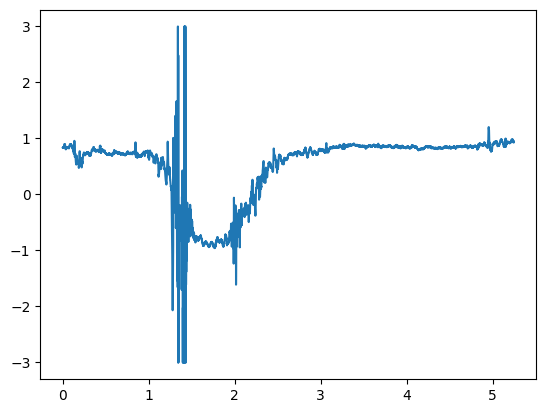

fs2:1342.3449513905803


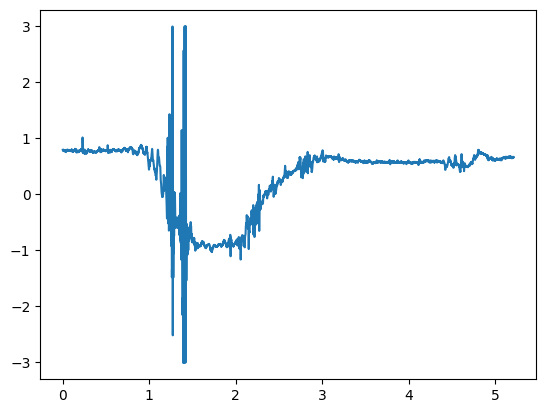

fs2:1347.6738617701374


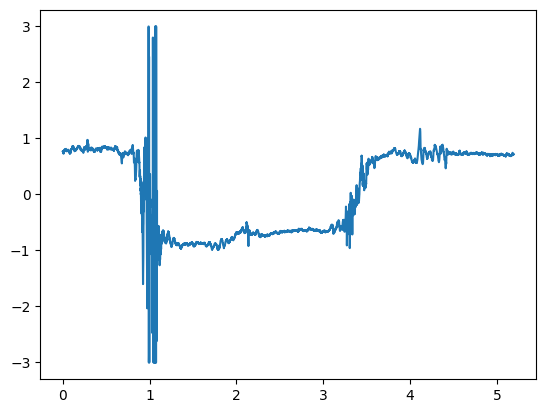

fs2:1336.9872685344374


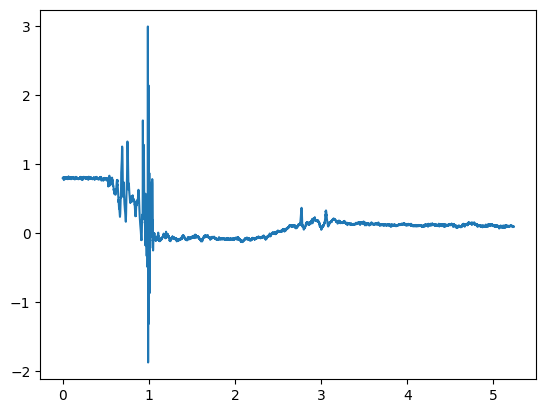

fs2:1343.6576823277626


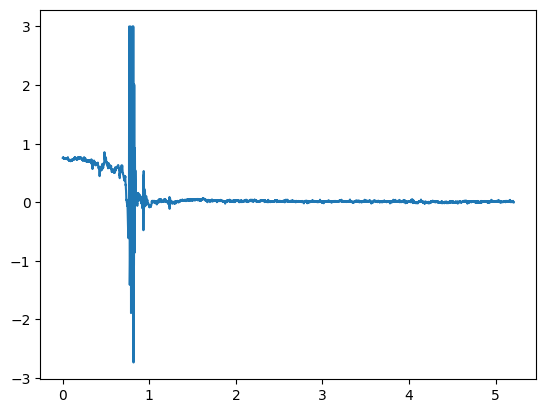

fs2:1322.1960809798343


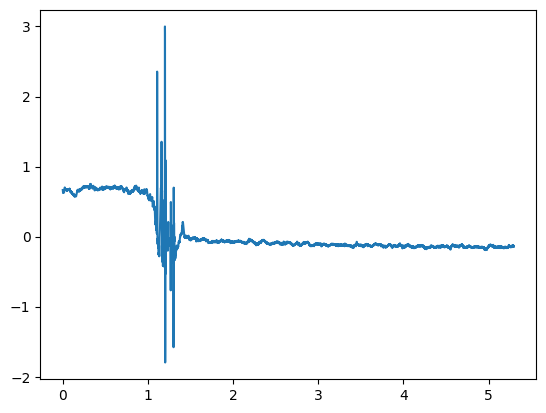

In [12]:
def plot_single_data(filename,fs=1330,forward=0.5,backward=0.7):
    df = pd.read_csv(filename)
    ACC_Z = df['ACC_Z']
    time = df['Time']

    # 滤波参数
    fs2 = 1/np.mean(np.diff(time))
    print(f"fs2:{fs2}")
    cutoff_L,cutoff_H = 500,20
    order_L,order_H = 6,5
    truncate_length = 0
    
   
    ACC_Z_filtered_L = butter_lowpass_filter(ACC_Z, cutoff_L, fs, order_L)
    ACC_Z_filtered_H = butter_highpass_filter(ACC_Z_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    time = time.values[truncate_length:]

    # 截取窗口
    # threshold = 1000 
    # peaks, _ = find_peaks(ACC_Z_filtered_H, height=threshold)
    # pivot = peaks[0]
    # start_index = pivot - int(forward*fs)
    # end_index = pivot + int(backward*fs)
    # print("index:",start_index,end_index)
    # plt.axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3, label='Target Waveform')
    
    plt.plot(time,ACC_Z/1000, label='ACC_Z Data')
    plt.show()
    
    return


# output2/20240328_092532.csv,0
# output2/20240328_091451.csv,0
# output2/20240328_091225.csv,0
# output2/20240328_090302.csv,1
# output2/20240328_083942.csv,1
# output2/20240328_084804.csv,1

plot_single_data('./output2/20240328_092532.csv',fs,forward,backward)
plot_single_data('./output2/20240328_091451.csv',fs,forward,backward)
plot_single_data('./output2/20240328_091225.csv',fs,forward,backward)
plot_single_data('./output2/20240328_090302.csv',fs,forward,backward)
plot_single_data('./output2/20240328_083942.csv',fs,forward,backward)
plot_single_data('./output2/20240328_084804.csv',fs,forward,backward)



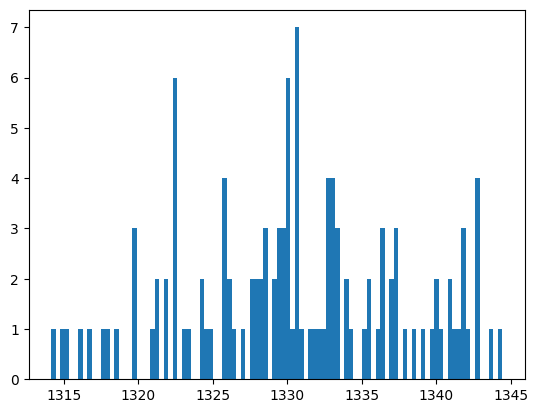

1330.4837978245776

In [15]:
def sr_check(labelFile):
    df = pd.read_csv(labelFile)
    filepaths = df['FilePath']
    n = len(filepaths)
    srs = np.empty(n)
    for ind,filepath in enumerate(filepaths):
        t = pd.read_csv(filepath)['Time']
        # print('t',t)
        # s = t.to_numpy(dtype=int)
        # print('s',s)
        srs[ind] = 1/np.mean(np.diff(t))
    
    plt.hist(srs, 100)
    plt.show()
    return np.mean(srs)

sr_check('label_file.csv')